In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import pandas as pd
from transformers import pipeline 
from transformers import AdamW,get_scheduler
from datasets import DatasetDict,Dataset
from datasets import load_dataset

In [ ]:
!nvidia-smi

Mon May  1 18:32:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# importing dataset

In [ ]:
data = pd.read_csv('data.txt', sep="\t", header=0)
data=Dataset.from_pandas(data)

In [ ]:
data

Dataset({
    features: ['value', 'label'],
    num_rows: 9196
})

In [ ]:
train_testvalid = data.train_test_split(test_size=0.2,seed=15)

# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)

# gather everyone if you want to have a single DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

data

DatasetDict({
    train: Dataset({
        features: ['value', 'label'],
        num_rows: 7356
    })
    test: Dataset({
        features: ['value', 'label'],
        num_rows: 920
    })
    valid: Dataset({
        features: ['value', 'label'],
        num_rows: 920
    })
})

# loading xlm roberta model

In [ ]:
model_directory="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer=AutoTokenizer.from_pretrained(model_directory)

# changing model output labels of model

In [ ]:
class CustomModel(nn.Module):
    def __init__(self,checkpoint,num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 

        #Load Model with given checkpoint and extract its body
        self.model = model =AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Linear(768,num_labels) # load and initialize weights

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

        logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CustomModel(checkpoint=model_directory,num_labels=5).to(device)
device

Some weights of the model checkpoint at citizenlab/twitter-xlm-roberta-base-sentiment-finetunned were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device(type='cuda')

# tokenizing the data

In [ ]:
def tokenize(batch):
  return tokenizer(batch["value"], truncation=True,max_length=512)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/7356 [00:00<?, ? examples/s]

Map:   0%|          | 0/920 [00:00<?, ? examples/s]

Map:   0%|          | 0/920 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['value', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7356
    })
    test: Dataset({
        features: ['value', 'label', 'input_ids', 'attention_mask'],
        num_rows: 920
    })
    valid: Dataset({
        features: ['value', 'label', 'input_ids', 'attention_mask'],
        num_rows: 920
    })
})

In [ ]:
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# loading data in dataloader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=6, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=6, collate_fn=data_collator
)

In [ ]:
from datasets import load_metric
metric = load_metric("f1")



<ipython-input-14-c2f3b55edd49>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


# cleaning gpu vram

In [ ]:
torch.cuda.empty_cache()

# training model

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

6130


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# validation set f1 score

In [ ]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

for epoch in range(num_epochs):
  model.train()
  for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar_train.update(1)

  model.eval()
  for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    #metric1.add_batch(predictions=predictions, references=batch["labels"])
    #metric2.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar_eval.update(1)
    
  print(metric.compute(average=None))
  #print(metric1.compute())
  #print(metric2.compute(average=None))
  

  0%|          | 0/6130 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': array([0.54938272, 0.89516129, 0.65306122, 0.68879668, 0.66176471])}
{'f1': array([0.67005076, 0.89705882, 0.66666667, 0.78074866, 0.69354839])}
{'f1': array([0.69633508, 0.92736318, 0.73469388, 0.74853801, 0.6962963 ])}
{'f1': array([0.71144279, 0.90647482, 0.74829932, 0.78      , 0.71186441])}
{'f1': array([0.71428571, 0.91353001, 0.73202614, 0.78306878, 0.6504065 ])}


# test set f1 score and accuracy

In [ ]:
metric1 =load_metric("accuracy")
model.eval()

test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=1, collate_fn=data_collator
)

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    #f1_score = f1_score(batch["labels"], predictions,average="None")
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    metric1.add_batch(predictions=predictions, references=batch["labels"])
  
print(metric.compute(average=None))
print(metric1.compute())

{'f1': array([0.70217918, 0.91035857, 0.69014085, 0.69798658, 0.6969697 ])}
{'accuracy': 0.8141304347826087}


# saving the model

In [ ]:
modelCheckpoint={
    "epoch":epoch,
    "model_state":model.state_dict(),
    "optim_state":optimizer.state_dict()
}
torch.save(modelCheckpoint,"modelCheckpoint1.pth")

In [ ]:
metric1 =load_metric("accuracy")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
modelCheckpoint={
    "epoch":epoch,
    "model_state":model.state_dict(),
    "optim_state":optimizer.state_dict()
}
torch.save(modelCheckpoint,"modelCheckpoint.pth")

In [ ]:
modelCheckpoint=torch.load("modelCheckpoint.pth")

In [ ]:
model.load_state_dict(modelCheckpoint["model_state"])

<All keys matched successfully>

In [ ]:
import numpy as np

In [ ]:
a={0:"Abusive/Offensive",
1:"Normal",
2:"Religious Hate",
3:"Sexism",
4:"Profane/Untargeted"}
l1=tokenizer("kse ho tum")
outputs=model(torch.tensor(np.array(l1['input_ids']).reshape(1,len(l1['input_ids'])),dtype=torch.int).to('cuda'))
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
print(predictions[0].item(),a[predictions[0].item()])

In [ ]:
def get_predict(l1):
  a={0:"Abusive/Offensive",
  1:"Normal",
  2:"Religious Hate",
  3:"Sexism",
  4:"Profane/Untargeted"}
  outputs=model(torch.tensor(np.array(l1['input_ids']).reshape(1,len(l1['input_ids'])),dtype=torch.int).to('cuda'))
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  print(predictions[0].item(),a[predictions[0].item()])




In [ ]:
l1=tokenizer("kse ho tum")
get_predict(l1)

1 Normal


In [ ]:
get_predict(tokenizer("allah karim ham pe rehm farmaye. "))

1 Normal


In [ ]:
get_predict(tokenizer("pehle apne aap ko to bacha le chutye yahudi agent"))

2 Religious Hate


In [ ]:
get_predict(tokenizer("tum jaisa laanti koi nh hy bharwy"))

0 Abusive/Offensive


In [ ]:
get_predict(tokenizer("bc nahi aa raha maza. koi is crowed ko jaga do. i'll pay for this"))

4 Profane/Untargeted


In [ ]:
get_predict(tokenizer("agar unmute na kre to bol dena chehre to langoor hai tera or tu hijra hai"))

3 Sexism


In [ ]:
get_predict(tokenizer("waisay.... mujy b nhi mily ga?"))

1 Normal


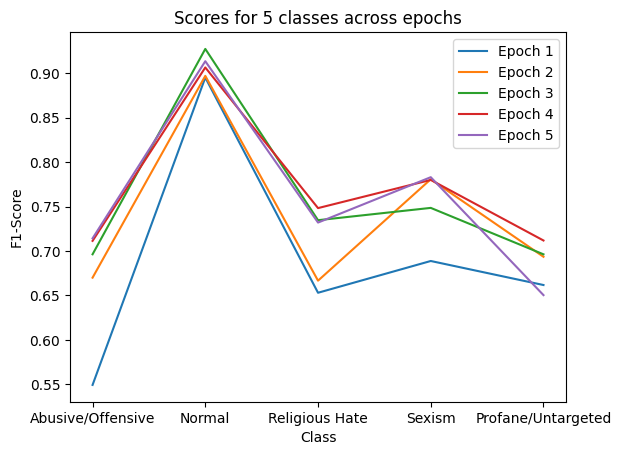

In [ ]:
import matplotlib.pyplot as plt

# Data for 5 classes
classes = ['Abusive/Offensive', 'Normal', 'Religious Hate', 'Sexism', 'Profane/Untargeted']

# Scores for each epoch
epoch1_scores = [0.54938272, 0.89516129, 0.65306122, 0.68879668, 0.66176471]
epoch2_scores = [0.67005076, 0.89705882, 0.66666667, 0.78074866, 0.69354839]
epoch3_scores = [0.69633508, 0.92736318, 0.73469388, 0.74853801, 0.6962963 ]
epoch4_scores = [0.71144279, 0.90647482, 0.74829932, 0.78      , 0.71186441]
epoch5_scores = [0.71428571, 0.91353001, 0.73202614, 0.78306878, 0.6504065 ]
# Set up the plot
fig, ax = plt.subplots()

# Create a line chart for each epoch
ax.plot(classes, epoch1_scores, label='Epoch 1')
ax.plot(classes, epoch2_scores, label='Epoch 2')
ax.plot(classes, epoch3_scores, label='Epoch 3')
ax.plot(classes, epoch4_scores, label='Epoch 4')
ax.plot(classes, epoch5_scores, label='Epoch 5')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('F1-Score')
ax.set_title('Scores for 5 classes across epochs')

# Add a legend
ax.legend()

# Show the plot
plt.show()
